In [1]:
import argparse
import os
import shutil
import gzip

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch
import torch.nn as nn
from torch.autograd import Variable

from dpp_nets.utils.language import Vocabulary, BeerDataset, custom_collate
from dpp_nets.layers.layers import ChunkTrainer, ChunkTrainerRel

from dpp_nets.utils.language import EvalSet

In [2]:
from dpp_nets.utils.language import Vocabulary

embd_path = '/Users/Max/data/beer_reviews/review+wiki.filtered.200.txt.gz'
word_path = '/Users/Max/data/beer_reviews/reviews.all.train.words.txt.gz'

# Set-up Vocabulary
vocab = Vocabulary()
vocab.loadPretrained(embd_path)
vocab.setStops()
vocab.loadCorpus(word_path)
vocab.updateEmbedding()
vocab.setCuda(False)

In [3]:
# Load saved checkpoint
model = 'allwords1reg0.1reg_mean20.0lr0.001marginal_best_ckp.pth.tar'
model_dir = '/Users/Max/checkpoints/beer_reviews/marginal/' 
model_path = model_dir + model
model = torch.load(model_path, map_location=lambda storage, loc: storage)
vocab.EmbeddingBag.load_state_dict(model['embedding'])

In [4]:
EMBD_DIM = 200
KERNEL_DIM = 200
HIDDEN_DIM = 500
ENC_DIM = 200
TARGET_DIM = 3 if model['aspect'] in set(['all', 'short']) else 1

if model['mode'] == 'sents':
    trainer = ChunkTrainer(EMBD_DIM, HIDDEN_DIM, KERNEL_DIM, ENC_DIM, TARGET_DIM)
else:
    trainer = ChunkTrainerRel(EMBD_DIM, HIDDEN_DIM, KERNEL_DIM, ENC_DIM, TARGET_DIM)

trainer.load_state_dict(model['model'])
trainer.activation = nn.Sigmoid()
trainer.reg = model['reg']
trainer.reg_mean = model['reg_mean']

rat_path = '/Users/Max/data/beer_reviews/annotations.json'
evalset = EvalSet(rat_path, vocab)

In [80]:
# Plot a table
print('__________________________Training Table__________________________')
for k, v in model['train_loss'].items():
    epoch, loss, pred_loss, reg_loss = k, v[0], model['train_pred_loss'][k][0], model['train_reg_loss'][k][0]
    print(str.join(" | ", ['Epoch: %d' % (epoch), 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

__________________________Training Table__________________________
Epoch: 0 | Loss: 0.02511 | Pred Loss: 0.02478 | Reg Loss: 0.00032
Epoch: 1 | Loss: 0.01997 | Pred Loss: 0.01983 | Reg Loss: 0.00014
Epoch: 2 | Loss: 0.01747 | Pred Loss: 0.01734 | Reg Loss: 0.00012
Epoch: 3 | Loss: 0.01518 | Pred Loss: 0.01506 | Reg Loss: 0.00012
Epoch: 4 | Loss: 0.01317 | Pred Loss: 0.01305 | Reg Loss: 0.00012


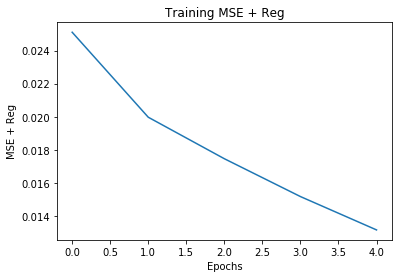

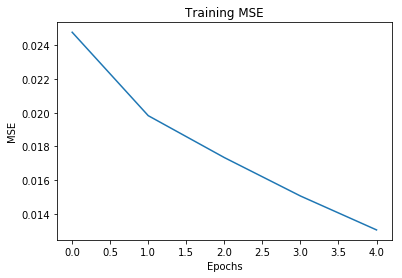

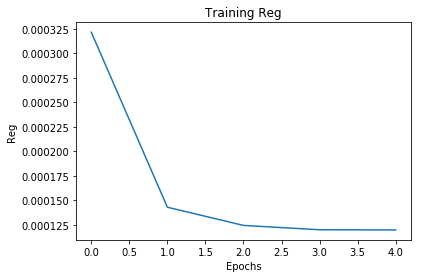

In [81]:
from dpp_nets.helper.plotting import plot_floats

# Training Plots
plot_floats(model['train_loss'], xlabel='Epochs', ylabel='MSE + Reg', title='Training MSE + Reg')
plot_floats(model['train_pred_loss'], xlabel='Epochs', ylabel='MSE', title='Training MSE')
plot_floats(model['train_reg_loss'], xlabel='Epochs', ylabel='Reg', title='Training Reg')

In [82]:
print('_________________________Validation Table_________________________')
for k, v in model['val_loss'].items():
    epoch, loss, pred_loss, reg_loss = k, v[0], model['val_pred_loss'][k][0], model['val_reg_loss'][k][0]
    print(str.join(" | ", ['Epoch: %d' % (epoch), 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

_________________________Validation Table_________________________
Epoch: 0 | Loss: 0.02213 | Pred Loss: 0.02197 | Reg Loss: 0.00016
Epoch: 1 | Loss: 0.01977 | Pred Loss: 0.01965 | Reg Loss: 0.00013
Epoch: 2 | Loss: 0.01919 | Pred Loss: 0.01907 | Reg Loss: 0.00012
Epoch: 3 | Loss: 0.01814 | Pred Loss: 0.01801 | Reg Loss: 0.00013
Epoch: 4 | Loss: 0.01784 | Pred Loss: 0.01771 | Reg Loss: 0.00012


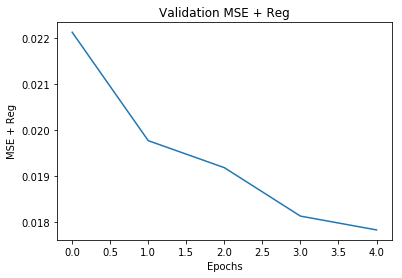

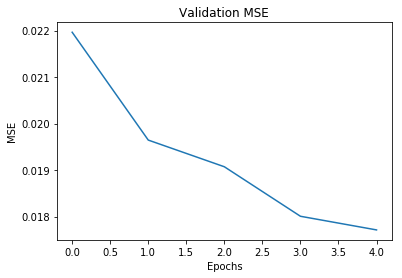

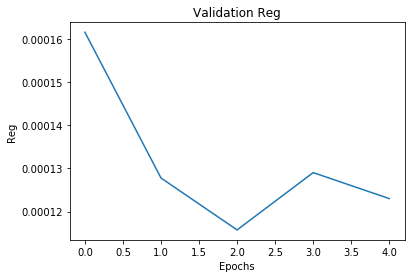

In [83]:
from dpp_nets.helper.plotting import plot_floats

# Training Plots
plot_floats(model['val_loss'], xlabel='Epochs', ylabel='MSE + Reg', title='Validation MSE + Reg')
plot_floats(model['val_pred_loss'], xlabel='Epochs', ylabel='MSE', title='Validation MSE')
plot_floats(model['val_reg_loss'], xlabel='Epochs', ylabel='Reg', title='Validation Reg')

In [84]:
# Evaluation on Test Set

loss, pred_loss, reg_loss = evalset.computeLoss(trainer, model['mode'])
print(str.join(" | ", ['Test Set:', 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

prec, extract = evalset.evaluatePrecision(trainer,model['mode'])
print(str.join(" | ", ['Test Set:', 'Precision: %.5f' % (prec), 'Extract: %.5f' % (extract)]))

Test Set: | Loss: 0.01270 | Pred Loss: 0.01257 | Reg Loss: 0.00013
Test Set: | Precision: 0.57678 | Extract: 0.05194


In [85]:
# Random Samples
evalset.sample(trainer, model['mode'],705)

index is: 705
('priced',) set() [('priced',)]
('california',) set() [('california',)]
('great',) set() [('great',)]
('bumping',) set() [('bumping',)]
('hoppy',) set() [('hoppy',)]
('clone',) set() [('clone',)]
Precision is: 0.0
Extraction Percentage is: 0.0759493670886076
[(Not a great fan of the style itself but it delivers well on the stone taste you get in all of the brewery's beers., set()), (It's a little too hoppy to be considered a straight belgian strong but a great california style clone of the style., set()), (Would recommend.		, set()), (This has turned into one of my favorite beers and is also very reasonably priced., set()), (I will be bumping up some of my numbers., set())]

 0.7862  0.6316  0.7216
[torch.FloatTensor of size 1x3]
 
 0.8000
 0.8000
 0.9000
[torch.FloatTensor of size 3]

Loss: 0.020941348746418953 Pred Loss 0.020133528858423233 Reg Loss 0.0008078195387497544


In [86]:
# Random Marginals
evalset.computeMarginals(trainer, model['mode'],100)

index is: 100
0 0.564455998703 ('weissbiers',)
1 0.486756061383 ('refreshing',)
2 0.432137292318 ('cheap',)
3 0.36758525177 ('flavours',)
4 0.358483722465 ('bubblegum',)
5 0.352812570674 ('ripe',)
6 0.350102163519 ('bananas',)
7 0.341474569695 ('outstanding',)
8 0.340770461107 ('great',)
9 0.330160887431 ('relatively',)
10 0.324261509213 ('cloudy',)
11 0.290086247417 ('cloves',)
12 0.282242301676 ('use',)
13 0.262787162139 ('golden',)
14 0.254278782568 ('hefe',)
15 0.25304389196 ('looking',)
16 0.238755204138 ('500',)
17 0.235480568217 ('much',)
18 0.217310177595 ('not',)
19 0.216432631764 ('ml',)
20 0.211428446777 ('still',)
21 0.204348065736 ('available',)
22 0.179603820375 ('large',)
23 0.177694428076 ('tasty',)
24 0.176051600984 ('back',)
25 0.171416105762 ('bodied',)
26 0.169077078591 ('could',)
27 0.161338209092 ('big',)
28 0.152920624624 ('flavour',)
29 0.143020900336 ('come',)
30 0.142822040344 ('aroma',)
31 0.140763378154 ('bite',)
32 0.138933813943 ('though',)
33 0.1348830079

In [87]:
evalset.computeMAPPredLoss(trainer, model['mode'])

(0.02494684590437939, 0.05193860046503281)

In [13]:
evalset.computeMUEPredLoss(trainer, model['mode'])

TypeError: computeMUEPredLoss() missing 1 required positional argument: 'n_runs'

In [ ]:
evalset.create_MAPS(trainer, model['mode'])

In [ ]:
good = []
bad = []

for m, t in evalset.MAPS:
    if t > 0.9:
        for tup in m:
            for word in tup:
                good.append(word)
    if t < 0.45:
        for tup in m:
            for word in tup:
                bad.append(word)

In [ ]:
l = []
for m, t in evalset.MAPS:
    for tup in m:
        for word in tup:
            l.append(word)

In [ ]:
from collections import Counter
import operator

all_revs = Counter(l)
good_revs = Counter(good)
bad_revs = Counter(bad)

sorted_good = sorted(good_revs.items(), key=operator.itemgetter(1))
sorted_good.reverse()

sorted_bad = sorted(bad_revs.items(), key=operator.itemgetter(1))
sorted_bad.reverse()

sorted_all = sorted(all_revs.items(), key=operator.itemgetter(1))
sorted_all.reverse()

In [ ]:
n_words = 20
for i in range(n_words):
    word, count = sorted_good[i]
    print(word, count)

In [ ]:
from dpp_nets.utils.language import Vocabulary, BeerDataset, simple_collate, custom_collate_reinforce, custom_collate

val_path = '/Users/Max/data/beer_reviews/' + 'reviews.' + model['aspect'] + '.heldout.' + model['mode'] + '.txt.gz'
val_set = BeerDataset(val_path)
val_loader = torch.utils.data.DataLoader(val_set, collate_fn=simple_collate, batch_size=1)

def compute_word_clouds(trainer, good_thres, bad_thres):
    
    words, target = custom_collate_reinforce(batch, vocab, args.alpha_iter, args.cuda)
    target_mean = target.data.mean()
    
    # Compute MAP
    kernel, _ = trainer.kernel_net(words)
    L = (kernel.data.mm(kernel.data.t())).numpy()
    return_ixs = computeMAP(L)

    MAP = []

    for i in return_ixs:
        txt = list(review.clean.keys())[i]
        label = list(review.clean.values())[i]
        rat = review.rev[txt]
        MAP.extend(rat)
    
    good = []
    bad = []

    
    

In [ ]:
for batch in val_loader:
    print(batch)

In [ ]:
review, target = batch[0]['review'], batch[0]['target']

In [ ]:
custom_collate(batch, evalset.vocab)

In [ ]:
# Count sizes - no tensor operations

# Map to Embeddings
rep = vocab.returnEmbds(d['review'])
rep

In [ ]:
evalset.words[0][2]

In [ ]:
torch.mean(torch.var(torch.stack(evalset.targets),0))

In [52]:
import numpy as np
sparsity = np.array([0.04, 0.08, 0.11, 0.19, 0.24, 0.3, 0.5, 1])
performance = np.array([0.014, 0.0136, 0.0127, 0.0111, 0.01123 , 0.0105, 0.0095, 0.0092])
SVMy = [0.015, 0.015]
SVMx = [0, 1]
constantx = [0, 1]
constanty = [0.0165, 0.0165]

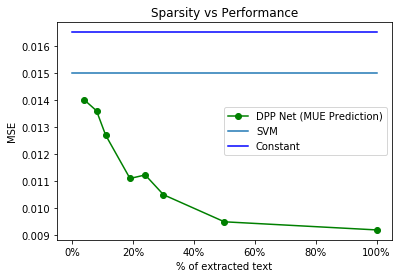

In [53]:
import matplotlib.pyplot as plt


plt.plot(sparsity, performance, marker='o', color='g', label='DPP Net (MUE Prediction)')
plt.plot(SVMx, SVMy, label='SVM')
plt.plot(constantx, constanty, label='Constant', color='b')
plt.ylabel('MSE')
plt.xlabel('% of extracted text')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0%', '20%', '40%','60%','80%','100%'])
plt.title('Sparsity vs Performance')
plt.legend()
plt.savefig('sparsityvsperformance')
plt.show()

In [77]:
evalset.reviews[705]

{'0': [],
 '1': [],
 '2': [],
 '3': [[26, 49]],
 '4': [[0, 26], [49, 52], [52, 68], [68, 78]],
 'raw': '{\'review/appearance\': 4.0, \'beer/style\': \'Belgian IPA\', \'review/palate\': 4.5, \'review/taste\': 4.0, \'beer/name\': \'Stone 08.08.08 Vertical Epic Ale\', \'review/timeUnix\': 1248218986, \'user/gender\': \'Male\', \'user/birthdayRaw\': \'Aug 20, 1960\', \'beer/ABV\': 8.6, \'beer/beerId\': \'44138\', \'user/birthdayUnix\': -295549200, \'beer/brewerId\': \'147\', \'review/timeStruct\': {\'isdst\': 0, \'mday\': 21, \'hour\': 23, \'min\': 29, \'sec\': 46, \'mon\': 7, \'year\': 2009, \'yday\': 202, \'wday\': 1}, \'user/ageInSeconds\': 1713884647, \'review/overall\': 3.5, \'review/text\': "Not a great fan of the style itself but it delivers well on the stone taste you get in all of the brewery\'s beers. It\'s a little too hoppy to be considered a straight belgian strong but a great california style clone of the style. Would recommend.\\t\\tThis has turned into one of my favorite be

In [5]:
evalset.reviews[713]

{'0': [[0, 5], [5, 8], [8, 14], [14, 23]],
 '1': [[23, 33], [33, 42]],
 '2': [[73, 82]],
 '3': [[42, 46], [46, 50], [50, 59], [59, 64], [64, 69], [69, 73]],
 '4': [[82, 100]],
 'raw': '{\'review/appearance\': 4.0, \'beer/style\': \'American Double / Imperial IPA\', \'review/palate\': 4.0, \'review/taste\': 4.0, \'beer/name\': \'Green Flash Imperial India Pale Ale\', \'review/timeUnix\': 1300608461, \'beer/ABV\': 9.4, \'beer/beerId\': \'34085\', \'beer/brewerId\': \'2743\', \'review/timeStruct\': {\'isdst\': 0, \'mday\': 20, \'hour\': 8, \'min\': 7, \'sec\': 41, \'mon\': 3, \'year\': 2011, \'yday\': 79, \'wday\': 6}, \'review/overall\': 4.0, \'review/text\': "Appearance: Golden Honey. Slightly Orange. It\'s a little opaque. It has a weak head with minimal retention.\\t\\tSmell: A huge dose of bread pale malts. There is a huge blast of very citric hops. \\t\\tTaste: Wow. This taste great. It has a good blend of cocoa malts. Very bitter piney hops. Slight tropical fruit sweetness. Apricot